In [1]:
import random
import numpy as np
import gym
import torch
import matplotlib.pyplot as plt

from dqn.agent import DQNAgent
from dqn.replay_buffer import ReplayBuffer
from dqn.wrappers import *

In [2]:
torch.cuda.is_available()

True

## DQN Hyperparameters

In [3]:
hyper_params = {
        "seed": 42,  # which seed to use
        "env": "PongNoFrameskip-v4",  # name of the game
        "replay-buffer-size": int(1e6),  # replay buffer size
        "learning-rate": 1e-4,  # learning rate for Adam optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 32,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 1,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.1,  # e-greedy end threshold
        "eps-fraction": 0.1,  # fraction of num-steps
        "print-freq": 10,
        }

## Initliase envrionment

In [4]:
def init_environment(output_folder='output'):
    np.random.seed(hyper_params["seed"])
    random.seed(hyper_params["seed"])

    assert "NoFrameskip" in hyper_params["env"], "Require environment with no frameskip"
    env = gym.make(hyper_params["env"])
    env.seed(hyper_params["seed"])

    env = NoopResetEnv(env, noop_max=30)   # No co-op max, as described in paper's parameter list
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)  # As described in training details section, when lives are up - so is the game
    env = FireResetEnv(env)  
    env = WarpFrame(env)    # Warp frame to 84x84 as described in paper
    env = PyTorchFrame(env) # Swap dimensions so channels are 1st -> Pytorch model needs this
    env = ClipRewardEnv(env)   #As described in Training details section
    env = FrameStack(env, 4)   # As described in hyperparameter list, agent history length
    env = gym.wrappers.Monitor(env, './' + output_folder + '/', video_callable=lambda episode_id: episode_id % 10 == 0, force=True)
    replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

    eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
    episode_rewards = [0.0]

    state = env.reset()
    return env, replay_buffer, eps_timesteps, episode_rewards, state

In [5]:
env, replay_buffer, eps_timesteps, episode_rewards, state = init_environment()

losses = []
average_rewards = []
average_rewards_epochs = []

agent = DQNAgent(env.observation_space,
                 env.action_space, 
                 replay_buffer, 
                 hyper_params["use-double-dqn"],
                 hyper_params["learning-rate"],
                 hyper_params["batch-size"],
                 hyper_params["discount-factor"])

## Training
(Optional)

In [5]:

for t in range(hyper_params["num-steps"] + 1):
    fraction = min(1.0, float(t) / eps_timesteps)
    eps_threshold = hyper_params["eps-start"] + fraction * (
                  hyper_params["eps-end"] - hyper_params["eps-start"])
    sample = random.random()
    # Annealing epsilon-greedy
    if sample <= eps_threshold:
        action = env.action_space.sample()
    else:
        action = agent.act(np.array(state))
            
    # Take a leap of faith in the environment
    next_state, reward, done, info = env.step(action)
    done = float(done)

    # Sum step reward for episode's total
    episode_rewards[-1] += reward

    # Store agent experience at each timestep
    replay_buffer.add(state, action, reward, next_state, done)

    # Update state
    state = next_state

    if done:
        state = env.reset()
        episode_rewards.append(0.0)

    if (t > hyper_params["learning-starts"]) and\
       (t % hyper_params["learning-freq"] == 0):
        loss = agent.optimise_td_loss()
        losses.append(loss)

    if (t > hyper_params["learning-starts"]) and\
       (t % hyper_params["target-update-freq"] == 0):
        agent.update_target_network()

    num_episodes = len(episode_rewards)

    if done and (len(episode_rewards) % hyper_params["print-freq"] == 0):
        mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
        average_rewards.append(round(np.mean(episode_rewards[ -hyper_params["print-freq"] - 1:-1]), 1))
        average_rewards_epochs.append(num_episodes)
        print("********************************************************")
        print("steps: {}".format(t))
        print("episodes: {}".format(num_episodes))
        print("mean 100 episode reward: {}".format(mean_100ep_reward))
        print("% time spent exploring: {}".format(int(100 * eps_threshold)))
        print("********************************************************")

********************************************************
steps: 7961
episodes: 10
mean 100 episode reward: -20.7
% time spent exploring: 92
********************************************************
********************************************************
steps: 17001
episodes: 20
mean 100 episode reward: -20.5
% time spent exploring: 84
********************************************************
********************************************************
steps: 26454
episodes: 30
mean 100 episode reward: -20.3
% time spent exploring: 76
********************************************************
********************************************************
steps: 36358
episodes: 40
mean 100 episode reward: -20.2
% time spent exploring: 67
********************************************************
********************************************************
steps: 45156
episodes: 50
mean 100 episode reward: -20.2
% time spent exploring: 59
********************************************************
***********

**Save the model weights** <br>
(Optional)

In [25]:
torch.save(agent.policy_network.state_dict(), 'DQN_model')

## Plots

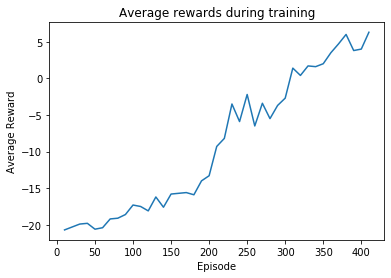

In [16]:
plt.figure(figsize=(12, 6));
plt.plot(average_rewards_epochs, average_rewards)
plt.title("Average rewards during training")
plt.ylabel("Average Reward")
plt.xlabel("Episode");

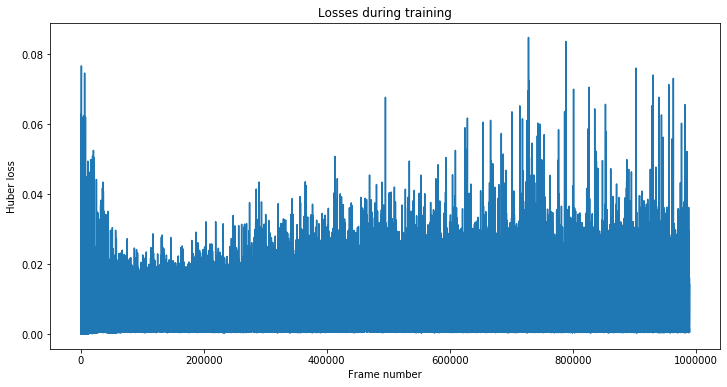

In [21]:
plt.figure(figsize=(12, 6));
plt.plot(losses)
plt.title("Losses during training")
plt.ylabel("Huber loss")
plt.xlabel("Frame number");

## Greedy evaluation run

**Load the model weights** <br>
(Optional)

In [10]:
agent.policy_network.load_state_dict(torch.load('DQN_model', map_location='cuda'));

In [9]:
env, replay_buffer, eps_timesteps, episode_rewards, state = init_environment('output_greedy')

agent.policy_network.eval()

while True:
  
  # Greedy only 
    action = agent.act(np.array(state))
            
  # Take a leap of faith in the environment
    next_state, reward, done, info = env.step(action)
    done = float(done)
        
    episode_rewards[-1] += reward

    # Store agent experience at each timestep
    replay_buffer.add(state, action, reward, next_state, done)

  # Update state
    state = next_state

    if done:
        state = env.reset()
        episode_rewards.append(0.0)

    num_episodes = len(episode_rewards)

    if (
      done
      and hyper_params["print-freq"] is not None
      and len(episode_rewards) % hyper_params["print-freq"] == 0
      ):
        mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
        print("********************************************************")
        print("episodes: {}".format(num_episodes))
        print("mean 100 episode reward: {}".format(mean_100ep_reward))
        print("********************************************************")
        break

********************************************************
episodes: 10
mean 100 episode reward: 4.9
********************************************************
